In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [2]:
# Path dataset
main_path = 'dataset'

In [3]:
# Membaca data dari folder
data = []
for folder in os.listdir(main_path):
    folder_path = os.path.join(main_path, folder)
    if os.path.isdir(folder_path):
        print(f"Reading folder: {folder}")
        for file in os.listdir(folder_path):
            if file.endswith('.jpg') or file.endswith('.jpeg'):
                data.append((os.path.join(folder_path, file), folder))

Reading folder: baterai
Reading folder: biologis
Reading folder: gelas
Reading folder: kardus
Reading folder: kertas
Reading folder: metal
Reading folder: pakaian
Reading folder: plastik
Reading folder: sepatu


In [4]:
# DataFrame dari data
df = pd.DataFrame(data, columns=['images', 'label'])
print(df['label'].value_counts())

label
biologis    5819
pakaian     5325
gelas       4552
plastik     4291
kertas      3715
kardus      2977
metal       2805
sepatu      1977
baterai      945
Name: count, dtype: int64


In [5]:
# Split dataset menjadi train, validation, dan test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1, stratify=train_df['label'])
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(20739, 2)
(5185, 2)
(6482, 2)


In [6]:
# Definisikan parameter gambar
img_height, img_width = 224, 224
batch_size = 32

In [7]:
# Preprocessing Data dengan Augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30, 
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.3,
    zoom_range=0.3,  
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],  
    channel_shift_range=0.2,
    validation_split=0.2  # Menambahkan split untuk validation set
)
# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=1,  # Seed untuk reproduktibilitas
    subset='training'  # Menentukan subset untuk train
)
# Validation generator
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,  # Jangan shuffle validation data
    seed=1,  # Seed untuk reproduktibilitas
    subset='validation'  # Menentukan subset untuk validation
)

# Test generator
test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,  # Jangan shuffle test data
    seed=1  # Seed untuk reproduktibilitas
)

Found 16592 validated image filenames belonging to 9 classes.
Found 4147 validated image filenames belonging to 9 classes.
Found 6482 validated image filenames belonging to 9 classes.


In [11]:
# Mendapatkan jumlah kelas
num_classes = len(train_df['label'].unique())
# Membangun model

for rate in dropout_rates:
    base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.6)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('model_best.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
]

In [13]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=15,  # Anda dapat menyesuaikan jumlah epoch
    callbacks=callbacks
)

Epoch 1/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 446s 849ms/step - accuracy: 0.4819 - loss: 1.5294 - val_accuracy: 0.7951 - val_loss: 0.6278 - learning_rate: 0.0010
Epoch 2/15
  1/518 ━━━━━━━━━━━━━━━━━━━━ 3:28 404ms/step - accuracy: 0.6875 - loss: 0.8930

c:\Users\adiaz\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6875 - loss: 0.8930 - val_accuracy: 0.8421 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 3/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 400s 768ms/step - accuracy: 0.7258 - loss: 0.8446 - val_accuracy: 0.8270 - val_loss: 0.5412 - learning_rate: 0.0010
Epoch 4/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - accuracy: 0.8750 - loss: 0.4335 - val_accuracy: 0.8421 - val_loss: 0.3449 - learning_rate: 0.0010
Epoch 5/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 418s 803ms/step - accuracy: 0.7621 - loss: 0.7270 - val_accuracy: 0.8425 - val_loss: 0.5013 - learning_rate: 0.0010
Epoch 6/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8125 - loss: 0.5186 - val_accuracy: 0.9474 - val_loss: 0.3135 - learning_rate: 0.0010
Epoch 7/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 418s 803ms/step - accuracy: 0.7875 - loss: 0.6721 - val_accuracy: 0.8537 - val_loss: 0.4822 - learning_rate: 0.0010
Epoch 8/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7188 - loss: 0.6490

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

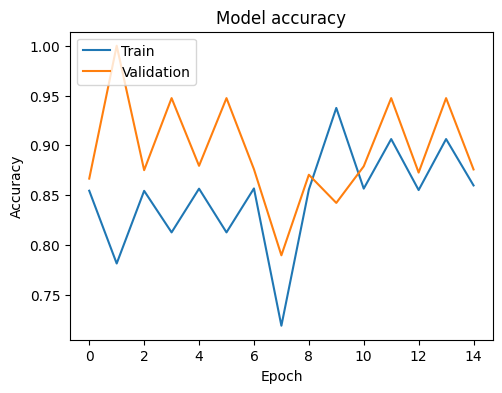

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

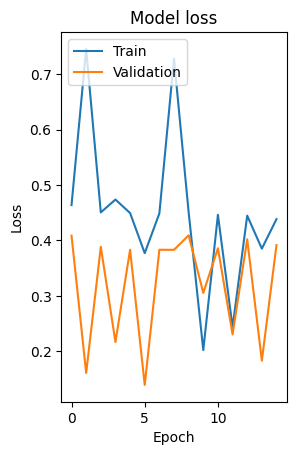

In [23]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 138s 681ms/step - accuracy: 0.8587 - loss: 0.4356
Test Loss: 0.4164065718650818
Test Accuracy: 0.8671706318855286


In [25]:
# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
class_labels = list(train_generator.class_indices.keys())

203/203 ━━━━━━━━━━━━━━━━━━━━ 127s 619ms/step


In [28]:
# Classification Report
print(classification_report(test_generator.classes, y_pred_classes, target_names=class_labels))

              precision    recall  f1-score   support

     baterai       0.87      0.81      0.84       189
    biologis       0.91      0.93      0.92      1164
       gelas       0.84      0.82      0.83       911
      kardus       0.86      0.81      0.83       596
      kertas       0.78      0.88      0.83       743
       metal       0.83      0.84      0.83       561
     pakaian       0.96      0.96      0.96      1065
     plastik       0.81      0.77      0.79       858
      sepatu       0.91      0.87      0.89       395

    accuracy                           0.87      6482
   macro avg       0.86      0.86      0.86      6482
weighted avg       0.87      0.87      0.87      6482



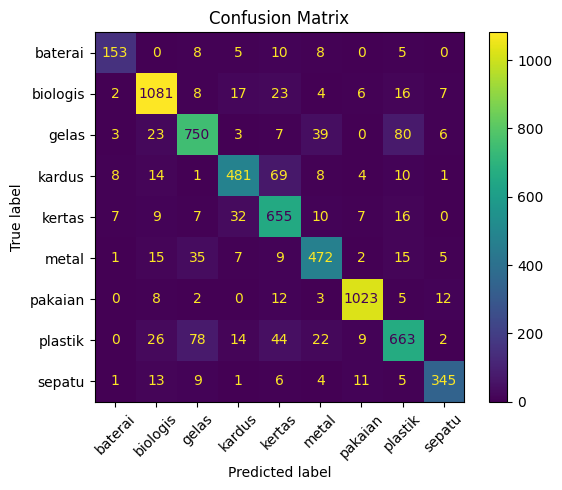

In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred_classes)
confusion_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
confusion_matrix_display.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.show()

In [29]:
# Save the model
model.save("ModelAkhir.keras")
model.save("ModelAkhir.h5")